In this notebook we present some basic application of random forest to
the parameterization of the L96 model previously introduced.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import L96_model_XYtend
from L96_model_XYtend import EulerFwd, RK2, RK4
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t

In [101]:
model = L96_model_XYtend.L96(8, 32)
X_history, Y_history, t, closure = model.run(0.05, 30., store=True)

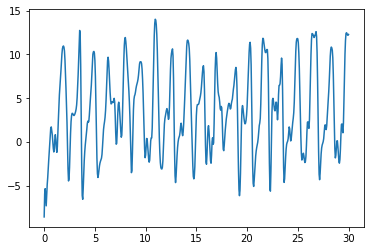

In [102]:
plt.figure()
plt.plot(t, X_history[:, 0])

In [103]:
closure.shape

(601, 8)

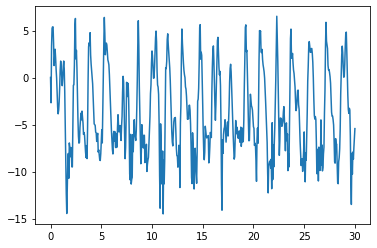

In [104]:
plt.figure()
plt.plot(t, closure[:, 0])

Scatter-plot of closure vs large-scale state X

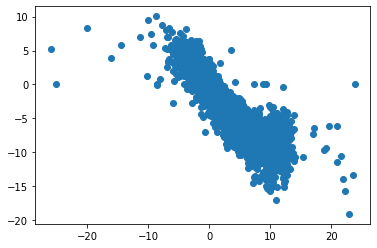

In [105]:
plt.figure()
plt.scatter(X_history.flatten(), closure.flatten())

## Starting with a single classification tree

We start with a very simple approach: we use a single value of the state as our feature (i.e. our feature is
one-dimensional).

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
closure.shape, X_history.shape

((601, 8), (601, 8))

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_history.flatten().reshape(-1, 1), closure.flatten(), test_size=0.33)

In [109]:
from sklearn import tree
single_tree = tree.DecisionTreeRegressor()
single_tree.fit(X_train, y_train)

DecisionTreeRegressor()

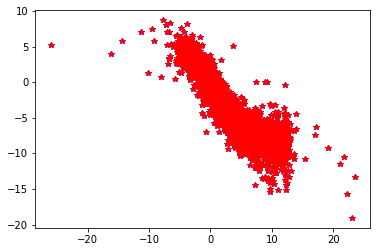

In [110]:
plt.figure()
plt.plot(X_train, y_train, 'b*')
plt.plot(X_train, single_tree.predict(X_train), 'r*')

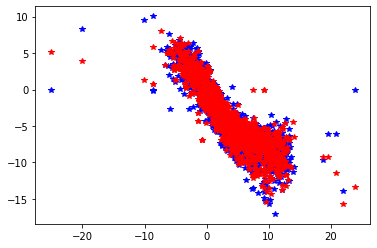

In [111]:
plt.figure()
plt.plot(X_test, y_test, 'b*')
plt.plot(X_test, single_tree.predict(X_test), 'r*')

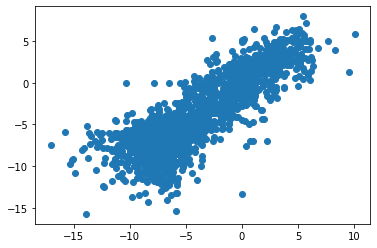

In [112]:
plt.figure()
plt.scatter(y_test, single_tree.predict(X_test))

Now let's implement this as a parameterization for L96.

In [113]:
class Parameterization:
    def __init__(self, predictor):
        self.predictor = predictor

    def __call__(self, X):
        X = X.reshape(-1, 1)
        return self.predictor.predict(X)

Here we use the GCM class defined by Yani in his notebook

In [133]:
class GCM:
    def __init__(self, F, parameterization, time_stepping=RK4):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self,X):
        return L96_eq1_xdot(X, self.F) +  self.parameterization(X)
        
    def __call__(self,X0, dt, nt):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [134]:
gcm = GCM(model.F, Parameterization(single_tree))
gcm_no_param = GCM(model.F, lambda x: 0)

In [155]:
model.set_state(model.X, model.Y)

L96: K=8 J=32 F=18 h=1 b=10 c=10 dt=0.001

In [161]:
n_steps = 2000

In [162]:
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)

In [163]:
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


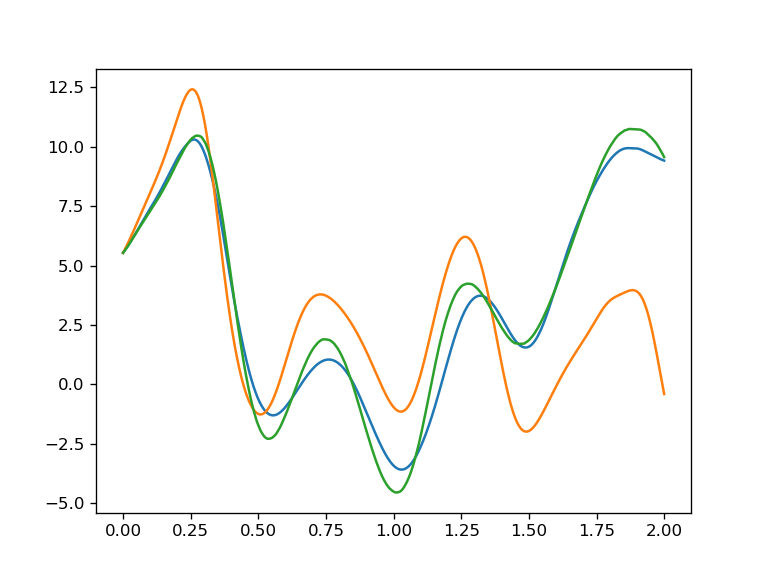

In [164]:
%matplotlib notebook
plt.figure()
plt.plot(t, X_true[:, 0])
plt.plot(t, X_no_param[:, 0])
plt.plot(t, X_param[:, 0])

<IPython.core.display.Javascript object>


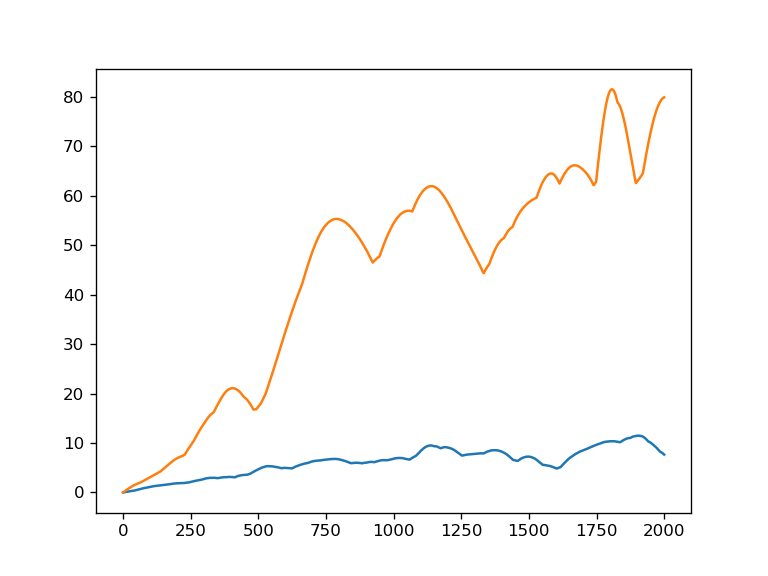

In [165]:
plt.figure()
plt.plot(abs(X_param - X_true).sum(axis=-1))
plt.plot(abs(X_no_param - X_true).sum(axis=-1))